In [27]:
from sklearn import datasets
digits = datasets.load_digits()
print(digits.keys())

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


In [28]:
# summary of data
print('data size = ', digits.data.shape)
print('target size = ', digits.target.shape)
print(digits.DESCR)

data size =  (1797, 64)
target size =  (1797,)
.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and t

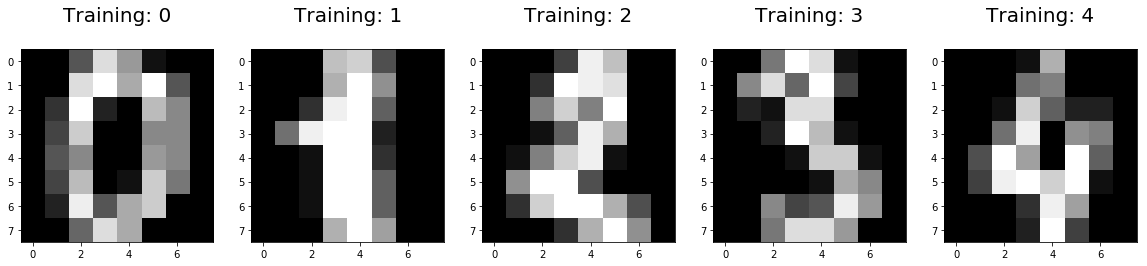

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# show examples of dataset
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(digits.data[0:5], digits.target[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

In [30]:
# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25, random_state=8)
print (X_train[256], y_train[256])

[ 0.  0.  2. 16. 10.  0.  0.  0.  0.  0.  4. 16. 16.  5.  0.  0.  0.  0.
  8. 16. 16.  3.  0.  0.  0.  0.  9. 16. 16.  3.  0.  0.  0.  0.  8. 16.
 16.  3.  0.  0.  0.  0.  8. 16. 16.  1.  0.  0.  0.  0.  5. 16. 14.  0.
  0.  0.  0.  0.  1. 12. 16.  3.  0.  0.] 1


In [77]:
# 3.2 batch gradient descent (GD) for Logistic regression

def LogisticRegression_GD(X_train, y_train, learning_rate):
    D = len(X_train[0])
    N = len(y_train) 
    C = 10
    y = np.zeros((N,C))
    X = np.hstack((X_train,np.ones((N,1))))
    eps = 1.0e-4
    for i in range(N):
        c = y_train[i]
        y[i,c] = 1
    W = np.random.rand(D+1,C)
    p = np.zeros((len(y_train),10))
    loss_GD = np.empty((2000,1),dtype='object')
    for t in range(2000):
        z=np.dot(X,W)
        max_z=(np.amax(z,axis=1).reshape(N,1))*np.ones((1,C))
        z=z-max_z
        for j in range(10):
            p[:,j] = np.exp(z[:,j])/np.sum(np.exp(z),axis=1)
        W_gradient = - (np.dot(X.T,(y - p)))/N+0.1*W
        W = W - (learning_rate * W_gradient)
#         if t > 1:
#             if abs(loss_GD[t] - loss_GD[t-1]) <= eps:                
#                 notstop = False
#                 break
        if np.amax(learning_rate * W_gradient)<eps:
            break
        predict=np.argmax(p,axis=1) 
        
        p_y = np.sum(np.multiply(p,y),axis=1)
        loss_GD[t]  = -np.mean(np.log(p_y))
             
    return W[0:D,:], W[D,:],predict,loss_GD


In [53]:
def precision(y_p,y_t):
    error = 0
    for k in range(len(y_t)):
        if y_p[k]!=y_t[k]:
            error = error + 1
    return 1-float(error/len(y_t))

---------------------------------------
learning rate = 0.05
training precision = 0.9925760950259837
test precision = 0.9666666666666667
---------------------------------------
learning rate = 0.005
training precision = 0.9844097995545658
test precision = 0.9533333333333334
---------------------------------------
learning rate = 0.01
training precision = 0.9888641425389755
test precision = 0.9711111111111111


Text(0,0.5,'loss_GD')

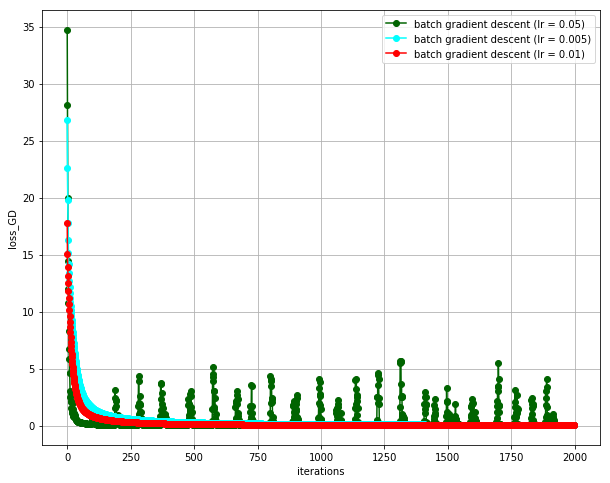

In [78]:
# evaluation of different learning rate
learning_rate = [5.0e-2,5.0e-3,1.0e-2]
cl = ['darkgreen', 'cyan', 'red']
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(len(learning_rate)):
    
    print ('---------------------------------------')
    print ('learning rate =', learning_rate[i])
    
    W, b, predict,loss_GD = LogisticRegression_GD(X_train, y_train, learning_rate[i])
    print ('training precision =', precision(predict,y_train))
    
    p = np.zeros((len(y_test),10))
    for j in range(10):
        p[:,j] = np.exp(np.dot(X_test,W[:,j]))/np.sum(np.exp(np.dot(X_test,W)),axis=1)
    predict = np.argmax(p,axis=1)
    print ('test precision =', precision(predict,y_test))
    t = np.linspace(0,len(loss_GD)-1,len(loss_GD))
    plt.plot(t,loss_GD, c = cl[i], ls = '-', marker = 'o', label = 'batch gradient descent (lr = ' + str(learning_rate[i]) + ')')
plt.grid()
plt.legend()
plt.xlabel('iterations')
plt.ylabel('loss_GD')

In [67]:
# 3.3 stochastic gradient descent (SGD) for Logistic regression

def LogisticRegression_SGD(X, y, batch_size, lr=1.0e-2, eta=2.0e-1, eps = 1.0e-4, max_epoch=1000):

    #TODO: initialization
    notstop = True
    epoch = 0
    loss = []  
    D = len(X_train[0])
    N = len(y_train) 
    C = 10
    y = np.zeros((N,C))
    X = np.hstack((X_train,np.ones((N,1))))
    for i in range(N):
        c = y_train[i]
        y[i,c] = 1
    W = np.random.rand(D+1,C)
    p = np.zeros((len(y_train),10))
    loss = np.empty((max_epoch,1),dtype='object') 
    batches = int(N/batch_size)

    # optimization loop	
    while notstop and epoch < max_epoch:
        
        #TODO: SGD of each epoch
        for i in range(batches):
            z=np.dot(X[i*batch_size:(i+1)*batch_size,:],W)
            max_z=(np.amax(z,axis=1).reshape(batch_size,1))*np.ones((1,C))
            z=z-max_z
            for j in range(10):
                p[i*batch_size:(i+1)*batch_size,j] = np.exp(z[:,j])/np.sum(np.exp(z),axis=1)
            W_gradient = - (np.dot(X[i*batch_size:(i+1)*batch_size,:].T,(y[i*batch_size:(i+1)*batch_size,:] - p[i*batch_size:(i+1)*batch_size,:])))/N+0.1*W
            W = W - (lr * W_gradient)
        # some data left
        if (i+1)*batch_size<N:
            m=N-((i+1)*batch_size)
            z=np.dot(X[(i+1)*batch_size:,:],W)
            max_z=(np.amax(z,axis=1).reshape(m,1))*np.ones((1,C))
            z=z-max_z
            for j in range(10):
                p[(i+1)*batch_size:,j] = np.exp(z[:,j])/np.sum(np.exp(z),axis=1)
            W_gradient = - (np.dot(X[(i+1)*batch_size:,:].T,(y[(i+1)*batch_size:,:] - p[(i+1)*batch_size:,:])))/N+0.1*W
            W = W - (lr * W_gradient)
        
            
        predict = np.argmax(p,axis=1)
        p_y = np.sum(np.multiply(p,y),axis=1)
        loss[epoch]  = -np.mean(np.log(p_y))
        
        # half lr if not improving in 10 epochs
        if epoch > 10:
            if loss[epoch - 10] <= loss[epoch] - eps:
                lr *= 0.5
                print ('reduce learning rate to', lr)
        
        # stop if not improving in 20 epochs
        if epoch > 20:
            if loss[epoch - 20] <= loss[epoch] - eps or abs(loss[epoch] - loss[epoch-1]) <= eps:                
                notstop = False
                break
            
        epoch += 1
        
        #TODO: W and b
        

    return W[0:D,:],W[D,:],predict,loss

---------------------------------------
batch_size = 10
training precision = 0.9740163325909428
test precision = 0.9511111111111111
---------------------------------------
batch_size = 50
training precision = 0.9725315515961396
test precision = 0.9511111111111111
---------------------------------------
batch_size = 100
training precision = 0.9755011135857461
test precision = 0.9511111111111111


Text(0,0.5,'loss_SGD')

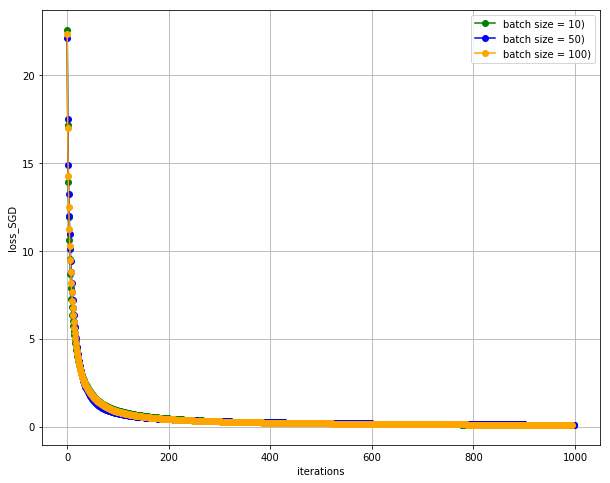

In [68]:
# evaluation of different batch size
bs = [10, 50, 100]
cl = ['green', 'blue', 'orange']
# TODO: different learning rate for different batch size
lr = [0.01, 0.01, 0.01]
fig, ax = plt.subplots(figsize=(10, 8))

for i in range(len(bs)):
    
    print ('---------------------------------------')
    print ('batch_size =', bs[i])
    W, b, pred, loss_SGD = LogisticRegression_SGD(X_train, y_train, bs[i], lr[i], 2.0e-1, 1.0e-4, 1000)
    print ('training precision =', precision(pred,y_train))

    #TODO
    p = np.zeros((len(y_test),10))
    for j in range(10):
        p[:,j] = np.exp(np.dot(X_test,W[:,j]))/np.sum(np.exp(np.dot(X_test,W)),axis=1)
    predict = np.argmax(p,axis=1)
    print ('test precision =', precision(predict,y_test))
    t = np.linspace(0,len(loss_SGD)-1,len(loss_SGD))
    plt.plot(t,loss_SGD, c = cl[i], ls = '-', marker = 'o', label = 'batch size = ' + str(bs[i]) + ')')
plt.grid()
plt.legend()
plt.xlabel('iterations')
plt.ylabel('loss_SGD')

In [79]:
# 3.3 stochastic gradient descent (SGD) for Logistic regression

def LogisticRegression_SGD(X, y, batch_size, lr=1.0e-2, eta=2.0e-1, eps = 1.0e-4, max_epoch=1000):

    #TODO: initialization
    notstop = True
    epoch = 0
    loss = []  
    D = len(X_train[0])
    N = len(y_train) 
    C = 10
    y = np.zeros((N,C))
    X = np.hstack((X_train,np.ones((N,1))))
    for i in range(N):
        c = y_train[i]
        y[i,c] = 1
    W = np.random.rand(D+1,C)
    p = np.zeros((len(y_train),10))
    loss = np.empty((max_epoch,1),dtype='object') 
    batches = int(N/batch_size)

    # optimization loop	
    while notstop and epoch < max_epoch:
        
        #TODO: SGD of each epoch
        for i in range(batches):
            z=np.dot(X[i*batch_size:(i+1)*batch_size,:],W)
            max_z=(np.amax(z,axis=1).reshape(batch_size,1))*np.ones((1,C))
            z=z-max_z
            for j in range(10):
                p[i*batch_size:(i+1)*batch_size,j] = np.exp(z[:,j])/np.sum(np.exp(z),axis=1)
            W_gradient = - (np.dot(X[i*batch_size:(i+1)*batch_size,:].T,(y[i*batch_size:(i+1)*batch_size,:] - p[i*batch_size:(i+1)*batch_size,:])))/N+0.1*W
            W = W - (lr * W_gradient)
        # some data left
        if (i+1)*batch_size<N:
            m=N-((i+1)*batch_size)
            z=np.dot(X[(i+1)*batch_size:,:],W)
            max_z=(np.amax(z,axis=1).reshape(m,1))*np.ones((1,C))
            z=z-max_z
            for j in range(10):
                p[(i+1)*batch_size:,j] = np.exp(z[:,j])/np.sum(np.exp(z),axis=1)
            W_gradient = - (np.dot(X[(i+1)*batch_size:,:].T,(y[(i+1)*batch_size:,:] - p[(i+1)*batch_size:,:])))/N+0.1*W
            W = W - (lr * W_gradient)
        
            
        predict = np.argmax(p,axis=1)
        p_y = np.sum(np.multiply(p,y),axis=1)
        loss[epoch]  = -np.mean(np.log(p_y))
        
        # half lr if not improving in 10 epochs
        if epoch > 10:
            if loss[epoch - 10] <= loss[epoch] - eps:
                lr *= 0.5
                print ('reduce learning rate to', lr)
        
        # stop if not improving in 20 epochs
        if epoch > 20:
            if loss[epoch - 20] <= loss[epoch] - eps or abs(loss[epoch] - loss[epoch-1]) <= eps:                
                notstop = False
                break
            
        epoch += 1
        
        #TODO: W and b
        

    return W[0:D,:],W[D,:],predict,loss

---------------------------------------
batch_size = 10
training precision = 0.9161098737936154
test precision = 0.88
---------------------------------------
batch_size = 50
reduce learning rate to 0.025
reduce learning rate to 0.0125
reduce learning rate to 0.00625
reduce learning rate to 0.003125
training precision = 0.9539717891610987
test precision = 0.9488888888888889
---------------------------------------
batch_size = 100
training precision = 0.9569413511507052
test precision = 0.9444444444444444


Text(0,0.5,'loss_SGD')

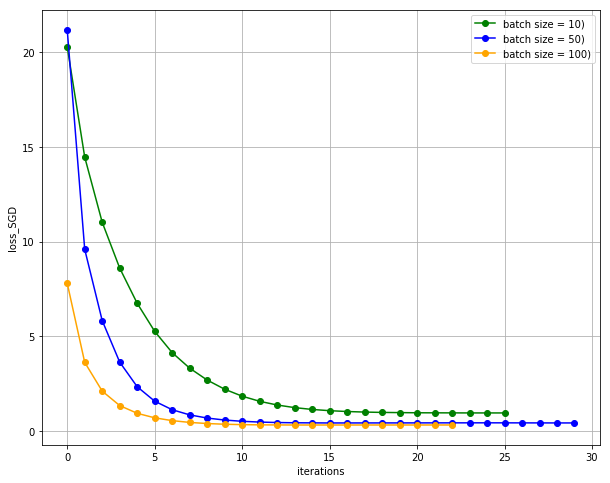

In [80]:
# evaluation of different initial learning rate
bs = [10, 50, 100]
cl = ['green', 'blue', 'orange']
# TODO: different learning rate for different batch size
lr = [0.01, 0.05, 0.1]
fig, ax = plt.subplots(figsize=(10, 8))

for i in range(len(bs)):
    
    print ('---------------------------------------')
    print ('batch_size =', bs[i])
    W, b, pred, loss_SGD = LogisticRegression_SGD(X_train, y_train, bs[i], lr[i], 2.0e-1, 1.0e-4, 1000)
    print ('training precision =', precision(pred,y_train))

    #TODO
    p = np.zeros((len(y_test),10))
    for j in range(10):
        p[:,j] = np.exp(np.dot(X_test,W[:,j]))/np.sum(np.exp(np.dot(X_test,W)),axis=1)
    predict = np.argmax(p,axis=1)
    print ('test precision =', precision(predict,y_test))
    t = np.linspace(0,len(loss_SGD)-1,len(loss_SGD))
    plt.plot(t,loss_SGD, c = cl[i], ls = '-', marker = 'o', label = 'batch size = ' + str(bs[i]) + ')')
plt.grid()
plt.legend()
plt.xlabel('iterations')
plt.ylabel('loss_SGD')